In [1]:
import torch
from tqdm import tqdm
import numpy as np
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils import data
import torch.utils.data as data_utils
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from matplotlib import pyplot as plt

In [2]:
# Saving workspace in google drive for convenience
import os
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [21]:
# Create workspace
WORKING_DIR = "./ml_projects/product_recommendation"
MODEL_DIR   = WORKING_DIR + os.sep + "prod_recommendation_enc"
MODEL_FILE  = MODEL_DIR + os.sep + "model.pt"
! [ -d $WORKING_DIR ] && echo "Directory exists" || mkdir -p $WORKING_DIR

# Removing old model checkpoint
! rm $MODEL_FILE  && rm $MODEL_DIR
! mkdir -p $MODEL_DIR

# cd workspace
%cd /content/drive/MyDrive/ml_projects/product_recommendation

/content/drive/MyDrive/ml_projects/product_recommendation


#Defining Dataset and Variational Autoencoder Model Components

In [4]:
def one_hot(class_index, num_classes=10):
    result = torch.zeros(num_classes)
    result[class_index] = 1
    return result

def collate_fn(batch):
    img_feat   = torch.stack([image for image, label in batch], 0)
    label_onehot = torch.stack([one_hot(label) for image, label in batch],0)
    return img_feat, label_onehot

class MnistDataset(data.Dataset):
    def __init__(self,split="train", train_ratio=0.8):
        self.split = split
        self.train_ratio = train_ratio
        self.transform   = transforms.ToTensor()
        self.mnist_train = torchvision.datasets.FashionMNIST(root="data", download=True, train=True, transform=self.transform)
        self.mnist_test  = torchvision.datasets.FashionMNIST(root="data", download=True, train=False, transform=self.transform)

        self.train_total = len(self.mnist_train)
        self.num_train   = int(self.train_total * self.train_ratio)

        if self.split == "train":
           self.data = data_utils.Subset(self.mnist_train,  torch.arange(0, self.num_train))
        if self.split == "dev":
           self.data = data_utils.Subset(self.mnist_train,  torch.arange(self.num_train, self.train_total))
        if self.split == "test":
           self.data = self.mnist_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if isinstance(index, slice):
            return [self.__getitem__(i) for i in range(*index.indices(len(self)))]  # type: ignore
        else:
            img, label = self.data[index]
            return img, label

In [5]:
class Encoder(nn.Module):
    def __init__(self, channel_dim, latent_dim, num_class):
        super().__init__()

        self.num_class = num_class
        self.latent_dim = latent_dim
        self.channel_dim = channel_dim
        channels_in  = [1, self.channel_dim]
        channels_out = [self.channel_dim, self.channel_dim*2]

        self.conv1 = nn.Conv2d(channels_in[0], channels_out[0], kernel_size=4, stride=2, padding=1) # in:[1,28,28], out: [c,14,14]
        self.conv2 = nn.Conv2d(channels_in[1], channels_out[1], kernel_size=4, stride=2, padding=1) # in:[c,14,14], out: [2*c,7,7]

        self.relu = nn.ReLU()

        self.fc = nn.Linear(channels_out[1]*7*7, 128)                   # in: 2*c*7*7 , out: 128
        self.fc_mu = nn.Linear(128+self.num_class, self.latent_dim)     # in: 128+num_class , out: latent_dim
        self.fc_logvar = nn.Linear(128+self.num_class, self.latent_dim) # in: 128+num_class , out: latent_dim

    def forward(self, x, y):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x_mu = self.fc_mu(torch.cat((x,y),1))
        x_logvar = self.fc_logvar(torch.cat((x,y),1))
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, channel_dim, latent_dim, num_class):
        super().__init__()

        self.num_class = num_class
        self.latent_dim = latent_dim
        self.channel_dim = channel_dim
        channels_in  = [self.channel_dim*2, self.channel_dim]
        channels_out = [self.channel_dim, 1]

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.fc1 = nn.Linear(in_features=latent_dim, out_features=128)   # in: latent_dim , out: 128
        self.fc2 = nn.Linear(in_features=128+self.num_class, out_features=channels_in[0]*7*7)  # in: 128+num_class , out: 2*c*7*7

        self.conv2 = nn.ConvTranspose2d(channels_in[0], channels_out[0], kernel_size=4, stride=2, padding=1)  # in:[2*c,7,7], out: [c,14,14]
        self.conv1 = nn.ConvTranspose2d(channels_in[1], channels_out[1], kernel_size=4, stride=2, padding=1)  # in:[c,14,14], out: [1,28,28]

    def forward(self, x,y):
        x = self.fc2(torch.cat((self.fc1(x),y),1))
        x = x.view(x.size(0), 2*self.channel_dim, 7, 7)
        x = self.relu(self.conv2(x))
        x = self.sigmoid(self.conv1(x))
        return x

class cond_VAE(nn.Module):
    def __init__(self, channel_dim=96, latent_dim=16, num_class=10, beta=1e-2):
        super().__init__()
        self.beta, self.channel_dim, self.latent_dim, self.num_class = beta, channel_dim, latent_dim, num_class
        self.encoder = Encoder(channel_dim=96, latent_dim=16, num_class=10)
        self.decoder = Decoder(channel_dim=96, latent_dim=16, num_class=10)

    def forward(self, x, y):
        latent_mu, latent_logvar = self.encoder(x, y)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent, y)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def vae_loss(self, recon_x, x, mu, logvar):
        recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='none').sum(axis=1)
        recon_loss_batch = recon_loss.mean()
        kldivergence = (1 + logvar - mu.pow(2) - logvar.exp()).sum(axis=1)
        kldivergence_batch = -0.5 * kldivergence.mean()

        return recon_loss_batch + self.beta * kldivergence_batch, self.beta * kldivergence_batch

In [6]:
train_dataset, dev_dataset= MnistDataset("train", train_ratio=0.9) , MnistDataset("dev", train_ratio=0.9)

100%|██████████| 26421880/26421880 [00:02<00:00, 12571313.62it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 203398.91it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3723515.03it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6264078.04it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



# Model Training ........

In [9]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

batch_size = 32
dev_loader = data.DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

device: cuda


In [10]:
vae = cond_VAE(channel_dim=128, latent_dim=10, num_class=10, beta=1e-2)
vae = vae.to(device)
loss_criterion = vae.vae_loss

print(vae, "\n")
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

learning_rate = 1e-3
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

cond_VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (relu): ReLU()
    (fc): Linear(in_features=9408, out_features=128, bias=True)
    (fc_mu): Linear(in_features=138, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=138, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (relu): ReLU()
    (sigmoid): Sigmoid()
    (fc1): Linear(in_features=16, out_features=128, bias=True)
    (fc2): Linear(in_features=138, out_features=9408, bias=True)
    (conv2): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): ConvTranspose2d(96, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
) 

Number of parameters: 3111969


In [11]:
# set to training mode
vae.train()
writer = SummaryWriter(MODEL_DIR)

num_epochs = 20
KL_loss, train_loss, val_KL_loss, val_loss = [],[],[],[]
print('Training ...')
for epoch in range(num_epochs):

    num_batches = 0
    KL_loss_sum, train_loss_sum, val_KL_loss_sum, val_loss_sum = 0,0,0,0
    # training.......
    tqdm_train_loader = tqdm(train_loader, leave=False)
    for image_batch, label_batch in tqdm_train_loader:

        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch, label_batch)

        # reconstruction error
        loss, kl_loss = loss_criterion(image_batch_recon, image_batch, latent_mu, latent_logvar)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_sum += loss.item()
        KL_loss_sum += kl_loss.item()

        # add stuff to progress bar in the end
        tqdm_train_loader.set_description(f"Epoch [{epoch}/{num_epochs}]")
        tqdm_train_loader.set_postfix(loss=loss.item(), kl_loss=kl_loss.item())

        num_batches += 1

    KL_loss.append(KL_loss_sum/num_batches)
    train_loss.append(train_loss_sum/num_batches)

    # validation.......
    tqdm_dev_loader = tqdm(dev_loader)
    vae.eval()
    num_batches = 0
    for image_batch, label_batch in tqdm_dev_loader:
        with torch.no_grad():

            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch, label_batch)

            # reconstruction error
            loss, kl_loss = loss_criterion(image_batch_recon, image_batch, latent_mu, latent_logvar)

        val_loss_sum += loss.item()
        val_KL_loss_sum += kl_loss.item()

        # add stuff to progress bar in the end
        tqdm_dev_loader.set_description(f"Val Epoch [{epoch+1}/{num_epochs}]")
        tqdm_dev_loader.set_postfix(val_loss=loss.item(), val_kl_loss=kl_loss.item())

        num_batches += 1
    vae.train()
    val_KL_loss.append(val_KL_loss_sum/num_batches)
    val_loss.append(val_loss_sum/num_batches)

    writer.add_scalars('Loss', {'train':train_loss[-1], 'dev':val_loss[-1]}, epoch)
    writer.add_scalars('KLdivergence', {'train':KL_loss[-1], 'dev':val_KL_loss[-1]}, epoch)

torch.save(
    {
        'model': vae.state_dict(),
        'opt': optimizer.state_dict()
    },MODEL_FILE)

writer.close()

print('')
print('Summarize Training ...')
print('Epoch [%d / %d] reconstruction error: %f, kl error: %f, dev reconstruction error: %f, dev kl error: %f'
      % (epoch+1, num_epochs, train_loss[-1], KL_loss[-1], val_loss[-1], val_KL_loss[-1]))

Training ...


Val Epoch [20/20]: 100%|██████████| 188/188 [00:02<00:00, 70.05it/s, val_kl_loss=0.591, val_loss=217]



Summarize Training ...
Epoch [20 / 20] reconstruction error: 209.029466, kl error: 0.615363, dev reconstruction error: 212.051734, dev kl error: 0.600564


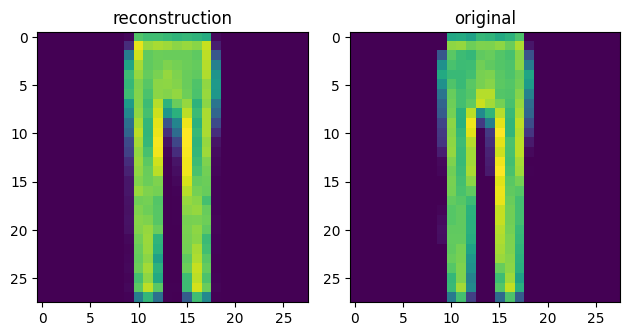

In [20]:
# @title Visualizing conditional VAE reconstruction image

sample_idx = 7 # @param @param {type:"integer"}

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('reconstruction')
ax1.imshow(image_batch_recon[sample_idx][0].cpu().detach().numpy(), interpolation='nearest')
ax2.set_title('original')
ax2.imshow(image_batch[sample_idx][0].cpu().detach().numpy(), interpolation='nearest')

fig.tight_layout()
fig.show()
